# Traffic Analysis

A trained YOLOv8n model is employed to generate tabular traffic flow data from images captured from a live feed at two-minute intervals.

## Todo
### Object Detection 
- train with labels accounting for traffic direction
- develop better plotting for predicted box plots 
- annotate more data with active learning 
- start training and detecting on other cameras to cross compare trends

### EDA tabular data 
- Look at hour level histograms across the different days 
- Explore trends that are worth modelling 

## Packages

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
import os 
from ultralytics import YOLO
import cv2

## Constants

In [ ]:
SEED=53456
CAMERA = '147'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# setting up the paths
cwd=os.getcwd()
root = os.path.dirname(cwd)
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train14', 'weights','best.pt')
processed_image_dir = os.path.join(root, 'dat','processed_images')
image_folder = os.path.join(processed_image_dir,CAMERA,'2024-11-13')
annotate_folder = os.path.join(root, 'dat','annotate',CAMERA,'2024-11-13')
output_folder = os.path.join(root, 'dat','output')
camera_dir = os.path.join(processed_image_dir, CAMERA)
tabular_csv_path = os.path.join(output_folder, 'traffic_oneway.csv')
image_file_path = os.path.join(image_folder, 'traffic_202411130652.jpg')

## Object detection: YOLOv8n

In [ ]:
# Load a model
model = YOLO(best_weights_path)  # pretrained YOLO11n model

### Single image detection 

In [ ]:
# Run batched inference on a list of images
image_paths = [image_file_path]
results = model(image_paths)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

In [ ]:
result.show()  # display to screen

### Detect cars from images in a day

In [40]:
# Run batched inference on a list of images
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
results = model(image_paths)  # return a list of Results objects

num_cars = []
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    num_cars.append(len(boxes.cls))
    #result.show()  # display to screen
    #result.save(filename="result.jpg")  # save to disk


0: 320x448 (no detections), 34.6ms
1: 320x448 3 incomings, 34.6ms
2: 320x448 2 incomings, 34.6ms
3: 320x448 (no detections), 34.6ms
4: 320x448 (no detections), 34.6ms
5: 320x448 2 incomings, 34.6ms
6: 320x448 1 incoming, 34.6ms
7: 320x448 1 incoming, 34.6ms
8: 320x448 1 incoming, 34.6ms
9: 320x448 4 incomings, 34.6ms
10: 320x448 1 incoming, 34.6ms
11: 320x448 1 incoming, 34.6ms
12: 320x448 1 incoming, 34.6ms
13: 320x448 1 incoming, 34.6ms
14: 320x448 1 incoming, 34.6ms
15: 320x448 1 incoming, 34.6ms
16: 320x448 (no detections), 34.6ms
17: 320x448 (no detections), 34.6ms
18: 320x448 (no detections), 34.6ms
19: 320x448 (no detections), 34.6ms
20: 320x448 (no detections), 34.6ms
21: 320x448 (no detections), 34.6ms
22: 320x448 (no detections), 34.6ms
23: 320x448 (no detections), 34.6ms
24: 320x448 (no detections), 34.6ms
25: 320x448 (no detections), 34.6ms
26: 320x448 (no detections), 34.6ms
27: 320x448 (no detections), 34.6ms
28: 320x448 2 incomings, 34.6ms
29: 320x448 (no detections), 3

### Plot results

It appears that with yolov8n the counts are very noisy. However, when aggregating to every 30 minutes by taking mean the trend is more clear. Should verify if noise seen in the plot at higher resolution is from the model or inherit to traffic conditions.

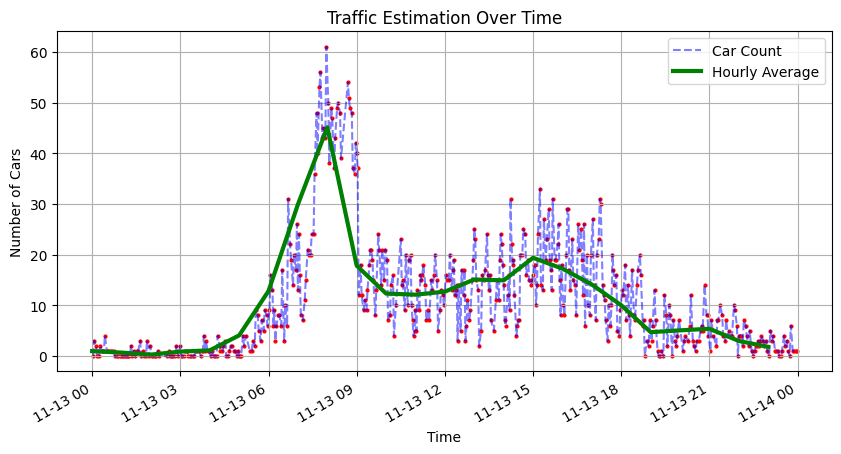

In [41]:
time_stamps = [
    datetime.strptime(string[8:-4], '%Y%m%d%H%M') for string in os.listdir(image_folder)
]


df = pd.DataFrame({'time': time_stamps, 
                   'num_cars': num_cars,
                   'image_paths': image_paths})
df.set_index('time', inplace=True)
df_hourly = df[['num_cars']].resample('h').mean().reset_index()


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.num_cars, label='Car Count', color='blue', linestyle='dashed', alpha=0.5)
plt.scatter(df.index, df.num_cars, s=4, color='red')

plt.plot(df_hourly['time'], df_hourly['num_cars'], label='Hourly Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Traffic Estimation Over Time')
plt.grid(True)
plt.legend()
plt.show()


### Generating tabular data from all the available dates

In [ ]:
df = pd.DataFrame({'time':[], 'class':[], 'confidence':[], 'num_cars':[]})
date_folders = os.listdir(camera_dir)

for date_folder in tqdm(date_folders):
    date_dir = os.path.join(camera_dir, date_folder)
    image_files = os.listdir(date_dir)
    image_paths = [os.path.join(date_dir, file) for file in image_files]
    if len(image_paths) == 0:
        continue
    results = model(image_paths)  
    for result, file in zip(results, image_files):
        cls = result.boxes.cls
        conf = result.boxes.conf
        num_cars = len(cls)
        date_string = file.split('_')[1].split('.')[0]
        date_object = datetime.strptime(date_string, '%Y%m%d%H%M')
        row = pd.DataFrame({'time':[date_object], 'class':[cls], 'confidence':[conf], 'num_cars':[num_cars]})
        df = pd.concat([df, row], ignore_index=True)

df['camera']=CAMERA

In [ ]:
df.to_csv(tabular_csv_path, index=False)

## Analyse tabular data

In [43]:
df = pd.read_csv(tabular_csv_path)

In [44]:
#group time column by days of the week 
df['time'] = pd.to_datetime(df['time'])
df['day_of_week'] = df['time'].dt.day_name()

#group time column by hours of the day
df['hour_of_day'] = df['time'].dt.hour 

df['time'].min(), df['time'].max()

(Timestamp('2024-10-28 00:02:00'), Timestamp('2024-12-12 18:50:00'))

Text(0, 0.5, 'Number of Cars')

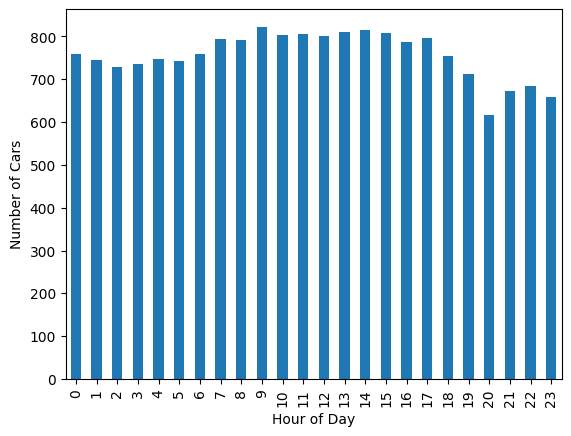

In [45]:
df['hour_of_day'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Cars')

Interestingly Monday and Friday does not contain the same morning traffic peaks Tuesday, Wednesday, and Thursday. Consider if mean or median is a better summary statistic here. 

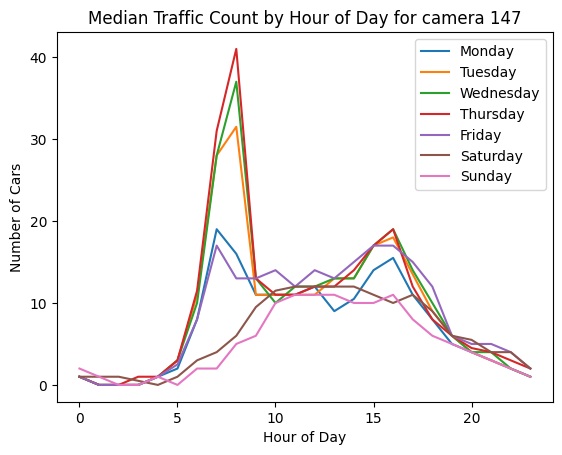

In [46]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['num_cars'].median().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Median Traffic Count by Hour of Day for camera {CAMERA}')

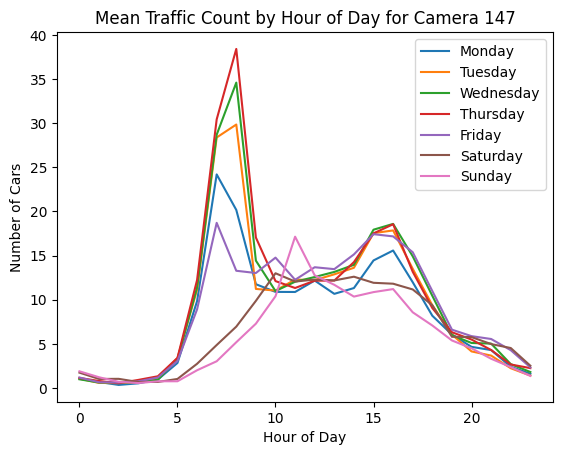

In [48]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['num_cars'].mean().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Mean Traffic Count by Hour of Day for Camera {CAMERA}')